# Reproduce the plot of the correlation between L_mm and M_BH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
from uncertainties import ufloat

import pandas as pd
from astropy.io import ascii
from astropy.table import Table
import astropy.units as u

from smbh_corona.constants import *
from smbh_corona.thermalsyn import *
from smbh_corona.corona_sed import t_ff

from astropy.cosmology import Planck18, z_at_value
from astropy import units as u

from smbh_corona.plot_utils import nice_fonts  # Import the nice_fonts settings

matplotlib.rcParams.update(nice_fonts)

## First reproduce the plot from Ruffa+2024

In [2]:
def fit_Ruffa(x):
    """The observed correlation by Ruffa+2024 (Eq.1)
    log10(M_BH) = (0.79 ± 0.08) * ( log10(L_nu) - 39 ) + (8.2 ± 0.1)
    Input:
    x: log10(L_nu)"""
    coeff1 = ufloat(0.79, 0.08)
    coeff2 = ufloat(8.2, 0.1)
    return coeff1 * (x - 39.0) + coeff2


def fit2_Ruffa(xr, mm):
    """The observed correlation by Ruffa+2024 (Eq.2)
    log10(M_BH) = (-0.23 ± 0.05) * ( log10(L_X) - 40 ) + (0.95 ± 0.07) * ( log10(L_nu) - 39 ) + (8.35 ± 0.08)
    Input:
    xr: log10(L_X,2-10keV)
    mm: log10(L_nu)"""
    coeff_xr = ufloat(-0.23, 0.05)
    coeff_mm = ufloat(0.95, 0.07)
    b = ufloat(8.35, 0.08)
    return coeff_xr * (xr - 40.0) + coeff_mm * (mm - 39) + b

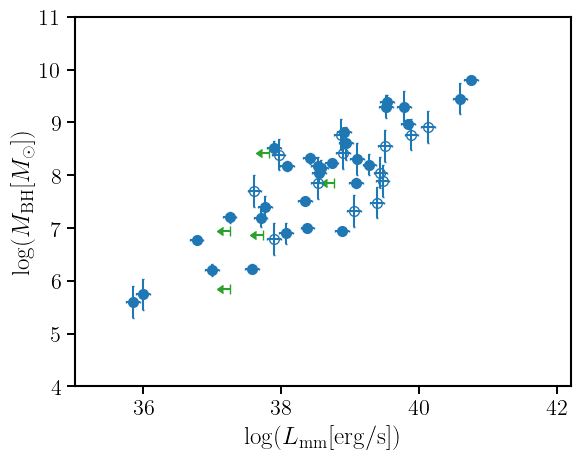

In [3]:
table_file = "Ruffa2024_TableA1.txt"
table = ascii.read(
    table_file,
    guess=True,
    data_start=2,
    names=[
        "Sample",
        "Galaxy",
        "D_Lum",
        "log(M_BH)",
        "d_log(M_BH)",
        "Method",
        "log(L_mm)",
        "log(L_X_2-10)",
        "d_log(L_X_2-10)",
    ],
)

## Check the column for upper limits and convert into strings
upper_limit_flags = []
new_values = []

for value in table["log(L_mm)"]:
    if value.startswith("<"):
        new_value = float(value[1:])
        upper_limit_flags.append(True)  # This value is an upper limit
    else:
        # Convert the value to float
        new_value = float(value)
        upper_limit_flags.append(False)  # This value is not an upper limit

    new_values.append(new_value)

# Update the table column with the new float values
table["log(L_mm)"] = np.array(new_values, dtype="float64")

# Add a new column to the table indicating which values are upper limits
table["is_upper_limit"] = upper_limit_flags


# Separate between sources in the literature (liter), the other sources, and upper limits (lim)
L_mm = table["log(L_mm)"][
    (table["Method"] == "σ⋆") & (table["is_upper_limit"] == False)
]
M_BH = table["log(M_BH)"][
    (table["Method"] == "σ⋆") & (table["is_upper_limit"] == False)
]
err_M_BH = table["d_log(M_BH)"][
    (table["Method"] == "σ⋆") & (table["is_upper_limit"] == False)
]

L_mm_lim = table["log(L_mm)"][(table["is_upper_limit"] == True)]
M_BH_lim = table["log(M_BH)"][(table["is_upper_limit"] == True)]

L_mm_liter = table["log(L_mm)"][
    (table["Method"] == "Dyn") & (table["is_upper_limit"] == False)
]
M_BH_liter = table["log(M_BH)"][
    (table["Method"] == "Dyn") & (table["is_upper_limit"] == False)
]
err_M_BH_liter = table["d_log(M_BH)"][
    (table["Method"] == "Dyn") & (table["is_upper_limit"] == False)
]


# Make a control plot
fig, ax = plt.subplots()
plt.xlim(35, 42.2)
plt.ylim(4, 11)

plt.errorbar(
    L_mm,
    M_BH,
    xerr=0.1,
    yerr=err_M_BH,
    color="C0",
    fmt="o",
    markersize=7,
    capsize=1,
    markerfacecolor="none",
)
plt.errorbar(
    L_mm_liter,
    M_BH_liter,
    xerr=0.1,
    yerr=err_M_BH_liter,
    color="C0",
    fmt="o",
    markersize=7,
    capsize=1,
)
plt.errorbar(
    L_mm_lim,
    M_BH_lim,
    xerr=0.1,
    xuplims=True,
    fmt="|",
    color="C2",
    alpha=1,
    markersize=7,
    label="_nolegend_",
)

plt.ylabel(r"$\log (M_{\rm BH} [M_\odot])$")
plt.xlabel(r"$\log (L_{\rm mm} [\mathrm{erg/s}])$")

plt.show()

## Add the sample sources

In [4]:
sources = {
    "GRS1734": {"logM": 7.84, "logM_err": 0.15, "logLmm": 39.34},
    "IC4329A": {"logM": 7.83, "logM_err": 0.07, "logLmm": 39.76},
    "MCG-6-30-15": {"logM": 7.3, "logM_err": 0.2, "logLmm": 38.23},
    "NGC985": {"logM": 8.34, "logM_err": 0.3, "logLmm": 40.09},
    "NGC1068": {"logM": 7.22, "logM_err": 0.004, "logLmm": 38.80},
}

# Extract data for plotting
names = list(sources.keys())
logM_values = [sources[name]["logM"] for name in names]
logM_errors = [sources[name]["logM_err"] for name in names]
logLmm = [sources[name]["logLmm"] for name in names]

## Define fiducial parameters for all systems

In [5]:
# Default parameters
params = {
    "d": 10e6 * pc,  # Source distance in cm
    "M": 1e8 * M_sun,  # Black hole mass
    "r_c": 140.0,  # R_c/R_g
    "tau_T": 0.25,  # Opacity
    "kT": 166,  # Corona temperature in keV
    "eps_B": 1.0,  # eps_B = U_mag/U_th
    "log_delta": -2.0,  # delta = U_NT/U_th
    "p": 2.7,  # Spectral index
}

# Derived parameters
params["T"] = params["kT"] * keV / k_B  # Corona temperature in K
params["theta_e"] = (k_B * params["T"]) / mec2  # Normalized temperature
params["dil"] = 4 * pi * params["d"] ** 2
params["z"] = z_at_value(
    Planck18.comoving_distance, params["d"] * u.cm, method="bounded"
).value
params["delta"] = 10 ** params["log_delta"]

# Use the energy condition U_B = eta_mag * U_NT (eps_B = eta_mag * delta*(1+xi_ep) ) to derive eps_B from delta.
# Note: eta_mag = 0.75 corresponds to the minimum energy condition, and xi_ep ~ 40 is the proton to electron ratio
eta_mag, xi_ep = 1.0, 40.0
params["eps_B"] = eta_mag * params["delta"] * (1 + xi_ep)

In [6]:
# Parameter to vary in the x axis
Ms = np.geomspace(8e5 * M_sun, 8e10 * M_sun, 100)  # SMBH masses

# Calculate at the reference (rest-frame) frequencies of 100 and 230 GHz
z = params["z"]
nu = np.array([150e9 * (1 + z), 230e9 * (1 + z)])

# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
eps_B = params["eps_B"]
delta = params["delta"]
p = params["p"]

# Use M_BH as the independent variable
Ms = np.geomspace(3e5 * M_sun, 9e10 * M_sun, 100)
L_150 = []
L_230 = []
for M in Ms:
    R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
    R_c = r_c * R_g  # Coronal radius
    n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
    t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
    U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G
    L_150_i, L_230_i = Lnu_fun(
        nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p
    )
    L_150.append(L_150_i)
    L_230.append(L_230_i)

# Luminosity convenient for plotting
log_L230 = [np.log10(L_i * 230e9) for L_i in L_230]

# Correlation
corr_values = [
    fit_Ruffa(x).nominal_value for x in log_L230
]  # Extract the nominal value
corr_errors = [
    fit_Ruffa(x).std_dev for x in log_L230
]  # Extract the standard deviation (uncertainty)

## Plot the correlation varying $\tau_T$ (having $T_c$ tied by the observed correlation)

In [7]:
def fit_par(x):
    """The observed correlation by Tortosa+2018 for a spherical geometry
    log10(kT) = a * log10(tau) + b
    Input:
    x: log10(tau)"""
    a = ufloat(-0.7, 0.2)
    b = ufloat(1.8, 0.1)
    return a * x + b

In [8]:
# Explore different values of tau and the corresponding temperatures
r_c = params["r_c"]
delta = 10 ** params["log_delta"]
p = params["p"]
tau_par = np.geomspace(0.1, 3.2, 6)
log10_kT = fit_par(np.log10(tau_par))
kT_val = np.power(
    10, [value.n for value in log10_kT]
)  # Extract nominal values and apply 10^x function
T_par = (kT_val / k_B) * 1e3 * eV
eps_B = eta_mag * delta * (1 + xi_ep)

# Luminosity convenient for plotting
log_L150_pars = []
log_L230_pars = []
for T, tau_T in zip(T_par, tau_par):
    log_L150_par = []
    log_L230_par = []
    for M in Ms:
        theta_e = (k_B * T) / mec2  # Normalized temperature
        R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
        R_c = r_c * R_g  # Coronal radius
        n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
        t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
        U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
        U_mag = eps_B * U_th
        B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G
        L_150_i, L_230_i = Lnu_fun(
            nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p
        )
        log_L150_par.append(np.log10(L_150_i * 230e9))
        log_L230_par.append(np.log10(L_230_i * 230e9))
    log_L150_pars.append(log_L150_par)
    log_L230_pars.append(log_L230_par)

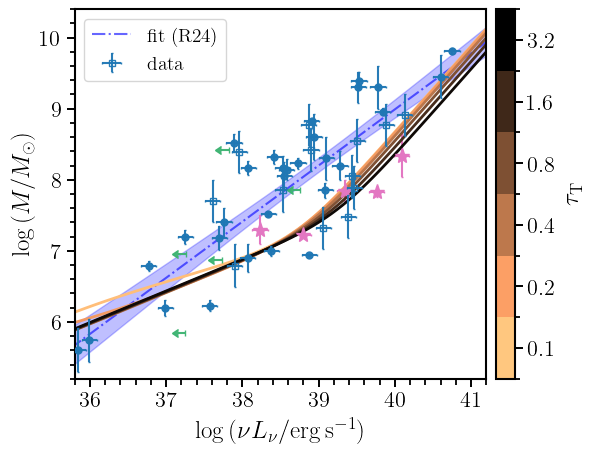

In [9]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, ylabel=r"$\log{( M/M_\odot )}$")
plt.setp(ax, xlabel=r"$\log{( \nu L_\nu/\mathrm{erg\,s}^{-1})}$")
xmin, xmax = min(log_L230), max(log_L230)
plt.xlim(35.8, 41.2)
plt.ylim(5.2, 10.4)

# Define a discrete palette avoiding extreme colors
n = len(tau_par)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot the observational points
plt.errorbar(
    L_mm,
    M_BH,
    xerr=0.1,
    yerr=err_M_BH,
    color="C0",
    fmt="s",
    alpha=0.96,
    markersize=5,
    capsize=1,
    markerfacecolor="none",
    label="data",
    zorder=3,
)
plt.errorbar(
    L_mm_liter,
    M_BH_liter,
    xerr=0.1,
    yerr=err_M_BH_liter,
    color="C0",
    fmt="o",
    alpha=0.96,
    markersize=5,
    capsize=1,
    zorder=3,
)
plt.errorbar(
    L_mm_lim,
    M_BH_lim,
    xerr=0.1,
    xuplims=True,
    fmt="|",
    color="#3CB371",
    alpha=0.96,
    markersize=5,
    zorder=3,
)

# Add my sources
plt.errorbar(
    logLmm,
    logM_values,
    xerr=0.1,
    yerr=logM_errors,
    color="C6",
    fmt="*",
    markersize=11,
    capsize=1,
)

# Plot for each value of M
for i in range(n):
    plt.plot(
        log_L230_pars[i],
        np.log10(Ms / M_sun),
        ls="-",
        color=colors[i],
        linewidth=2,
        label="",
        zorder=2,
    )

plt.plot(
    log_L230, corr_values, ls="-.", color="blue", label="fit (R24)", zorder=1, alpha=0.6
)

plt.fill_between(
    log_L230,
    [y + e for y, e in zip(corr_values, corr_errors)],
    [y - e for y, e in zip(corr_values, corr_errors)],
    color="blue",
    alpha=0.25,
    edgecolor="blue",
    linewidth=1,
    label="",
    zorder=1,
)

# Add ten subticks per tick on both x and y axes
subticks_per_tick = 5
major_locator_x = MultipleLocator(1)  # Major tick at each integer value on x-axis
minor_locator_x = MultipleLocator(1 / subticks_per_tick)  # Subticks on x-axis
major_locator_y = MultipleLocator(1)  # Major tick at each 0.2 value on y-axis
minor_locator_y = MultipleLocator(1 / subticks_per_tick)  # Subticks on y-axis

plt.gca().xaxis.set_major_locator(major_locator_x)
plt.gca().xaxis.set_minor_locator(minor_locator_x)
plt.gca().yaxis.set_major_locator(major_locator_y)
plt.gca().yaxis.set_minor_locator(minor_locator_y)

cbar = fig.colorbar(sm, ticks=co, label=r"$\tau_\mathrm{T}$", pad=0.02, ax=plt.gca())
betas_labels = ["{:.1f}".format(tau) for tau in tau_par]
cbar.ax.set_yticklabels(betas_labels)  # vertically oriented colorbar

ax.legend(loc="best")
plt.show()
fig.savefig("correlation_L-vs-tauT_range.pdf", bbox_inches="tight", pad_inches=0.01)

## Plot the correlation varying the value of $r_c$

In [10]:
# Explore different values of tau and the corresponding temperatures
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
eps_B = params["eps_B"]
delta = params["delta"]
p = params["p"]
z = params["z"]
theta_e = params["theta_e"]
eps_B = params["eps_B"]

r_cs = np.geomspace(20, 350, 6)

# Luminosity convenient for plotting
log_L150_pars = []
log_L230_pars = []
for r_c in r_cs:
    log_L150_par = []
    log_L230_par = []
    for M in Ms:
        R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
        R_c = r_c * R_g  # Coronal radius
        n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
        t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
        U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
        U_mag = eps_B * U_th
        B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G
        L_150_i, L_230_i = Lnu_fun(
            nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p
        )
        log_L150_par.append(np.log10(L_150_i * 230e9))
        log_L230_par.append(np.log10(L_230_i * 230e9))
    log_L150_pars.append(log_L150_par)
    log_L230_pars.append(log_L230_par)

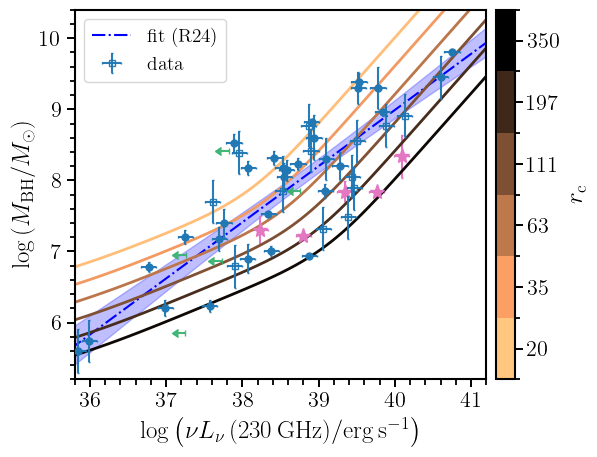

In [11]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, ylabel=r"$\log{( M_\mathrm{BH}/M_\odot )}$")
plt.setp(
    ax,
    xlabel=r"$\log{ \left( \nu L_\nu \,\mathrm{(230\,GHz)}/\mathrm{erg\,s}^{-1} \right)}$",
)
xmin, xmax = min(log_L230), max(log_L230)
plt.xlim(35.8, 41.2)
plt.ylim(5.2, 10.4)

# Define a discrete palette avoiding extreme colors
n = len(r_cs)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)


# Plot the observational points
plt.errorbar(
    L_mm,
    M_BH,
    xerr=0.1,
    yerr=err_M_BH,
    color="C0",
    fmt="s",
    alpha=0.96,
    markersize=5,
    capsize=1,
    markerfacecolor="none",
    label="data",
    zorder=3,
)
plt.errorbar(
    L_mm_liter,
    M_BH_liter,
    xerr=0.1,
    yerr=err_M_BH_liter,
    color="C0",
    fmt="o",
    alpha=0.96,
    markersize=5,
    capsize=1,
    zorder=3,
)
plt.errorbar(
    L_mm_lim,
    M_BH_lim,
    xerr=0.1,
    xuplims=True,
    fmt="|",
    color="#3CB371",
    alpha=0.96,
    markersize=5,
    zorder=3,
)

# Add my sources
plt.errorbar(
    logLmm,
    logM_values,
    xerr=0.1,
    yerr=logM_errors,
    color="C6",
    fmt="*",
    markersize=11,
    capsize=1,
)

# Plot for each value of M
for i in range(n):
    plt.plot(
        log_L230_pars[i],
        np.log10(Ms / M_sun),
        ls="-",
        color=colors[i],
        linewidth=2,
        label="",
        zorder=2,
    )

plt.plot(log_L230, corr_values, ls="-.", color="blue", label="fit (R24)", zorder=1)

plt.fill_between(
    log_L230,
    [y + e for y, e in zip(corr_values, corr_errors)],
    [y - e for y, e in zip(corr_values, corr_errors)],
    color="blue",
    alpha=0.25,
    edgecolor="blue",
    linewidth=1,
    label="",
    zorder=1,
)


# Add ten subticks per tick on both x and y axes
subticks_per_tick = 5
major_locator_x = MultipleLocator(1)  # Major tick at each integer value on x-axis
minor_locator_x = MultipleLocator(1 / subticks_per_tick)  # Subticks on x-axis
major_locator_y = MultipleLocator(1)  # Major tick at each 0.2 value on y-axis
minor_locator_y = MultipleLocator(1 / subticks_per_tick)  # Subticks on y-axis

plt.gca().xaxis.set_major_locator(major_locator_x)
plt.gca().xaxis.set_minor_locator(minor_locator_x)
plt.gca().yaxis.set_major_locator(major_locator_y)
plt.gca().yaxis.set_minor_locator(minor_locator_y)

cbar = fig.colorbar(sm, ticks=co, label=r"$r_\mathrm{c}$", pad=0.02, ax=plt.gca())
betas_labels = ["{:.0f}".format(r_c) for r_c in r_cs]
cbar.ax.set_yticklabels(betas_labels)  # vertically oriented colorbar

ax.legend(loc="best")
plt.show()
fig.savefig("correlation_L-vs-rc_range.pdf", bbox_inches="tight", pad_inches=0.01)

## Plot the correlation varying the value of $\log{\delta}$

In [12]:
# Explore different values of tau and the corresponding temperatures
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
eps_B = params["eps_B"]
p = params["p"]
z = params["z"]
theta_e = params["theta_e"]
eps_B = params["eps_B"]

deltas = np.geomspace(10**-2.5, 1e-1, 6)

# '''Use the energy condition U_B = eta_mag * U_NT (eps_B = eta_mag * delta*(1+xi_ep) ) to derive eps_B from delta.
# Note: eta_mag = 0.75 corresponds to the minimum energy condition, and xi_ep ~ 40 is the proton to electron ratio'''
eta_mag, xi_ep = 1.0, 40.0

# Luminosity convenient for plotting
log_L150_pars = []
log_L230_pars = []
for delta in deltas:
    log_L150_par = []
    log_L230_par = []
    eps_B = eta_mag * delta * (1 + xi_ep)
    for M in Ms:
        R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
        R_c = r_c * R_g  # Coronal radius
        n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
        t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
        U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
        U_mag = eps_B * U_th
        B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

        L_150_i, L_230_i = Lnu_fun(
            nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p
        )
        # print(L_150_i)
        log_L150_par.append(np.log10(L_150_i * 230e9))
        log_L230_par.append(np.log10(L_230_i * 230e9))
    log_L150_pars.append(log_L150_par)
    log_L230_pars.append(log_L230_par)

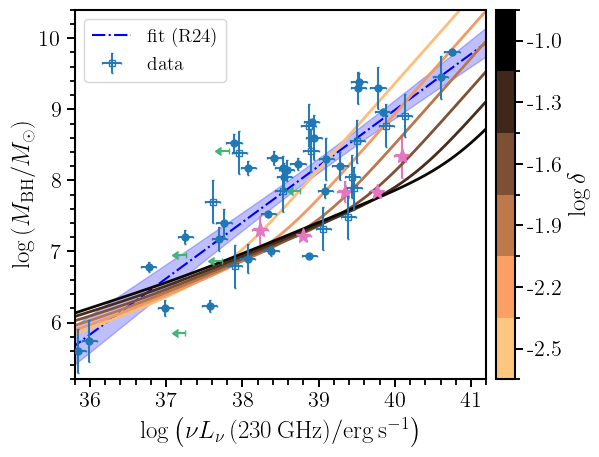

In [13]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, ylabel=r"$\log{( M_\mathrm{BH}/M_\odot )}$")
plt.setp(
    ax,
    xlabel=r"$\log{ \left( \nu L_\nu \,\mathrm{(230\,GHz)}/\mathrm{erg\,s}^{-1} \right)}$",
)  # For luminosities
xmin, xmax = min(log_L230), max(log_L230)
plt.xlim(35.8, 41.2)
plt.ylim(5.2, 10.4)

# Define a discrete palette avoiding extreme colors
n = len(deltas)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)


# Plot the observational points
plt.errorbar(
    L_mm,
    M_BH,
    xerr=0.1,
    yerr=err_M_BH,
    color="C0",
    fmt="s",
    alpha=0.96,
    markersize=5,
    capsize=1,
    markerfacecolor="none",
    label="data",
    zorder=3,
)
plt.errorbar(
    L_mm_liter,
    M_BH_liter,
    xerr=0.1,
    yerr=err_M_BH_liter,
    color="C0",
    fmt="o",
    alpha=0.96,
    markersize=5,
    capsize=1,
    zorder=3,
)
plt.errorbar(
    L_mm_lim,
    M_BH_lim,
    xerr=0.1,
    xuplims=True,
    fmt="|",
    color="#3CB371",
    alpha=0.96,
    markersize=5,
    zorder=3,
)

# Add my sources
plt.errorbar(
    logLmm,
    logM_values,
    xerr=0.1,
    yerr=logM_errors,
    color="C6",
    fmt="*",
    markersize=11,
    capsize=1,
)

# Plot for each value of M
for i in range(n):
    plt.plot(
        log_L230_pars[i],
        np.log10(Ms / M_sun),
        ls="-",
        color=colors[i],
        linewidth=2,
        label="",
        zorder=2,
    )

plt.plot(log_L230, corr_values, ls="-.", color="blue", label="fit (R24)", zorder=1)

plt.fill_between(
    log_L230,
    [y + e for y, e in zip(corr_values, corr_errors)],
    [y - e for y, e in zip(corr_values, corr_errors)],
    color="blue",
    alpha=0.25,
    edgecolor="blue",
    linewidth=1,
    label="",
    zorder=1,
)

# Add ten subticks per tick on both x and y axes
subticks_per_tick = 5
major_locator_x = MultipleLocator(1)  # Major tick at each integer value on x-axis
minor_locator_x = MultipleLocator(1 / subticks_per_tick)  # Subticks on x-axis
major_locator_y = MultipleLocator(1)  # Major tick at each 0.2 value on y-axis
minor_locator_y = MultipleLocator(1 / subticks_per_tick)  # Subticks on y-axis

plt.gca().xaxis.set_major_locator(major_locator_x)
plt.gca().xaxis.set_minor_locator(minor_locator_x)
plt.gca().yaxis.set_major_locator(major_locator_y)
plt.gca().yaxis.set_minor_locator(minor_locator_y)

cbar = fig.colorbar(sm, ticks=co, label=r"$\log{\delta}$", pad=0.02, ax=plt.gca())
betas_labels = ["{:.1f}".format(np.log10(delta)) for delta in deltas]
cbar.ax.set_yticklabels(betas_labels)  # vertically oriented colorbar

ax.legend(loc="best")
plt.show()
fig.savefig("correlation_L-vs-delta_range.pdf", bbox_inches="tight", pad_inches=0.01)